### Titanic Model using MLP
<div style="font-size: 12px"/>
The sinking of the Titanic is one of the most infamous shipwrecks in history. On April
15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank
after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
In this challenge, we ask you to build a predictive model that answers the question:
“what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

| Variable | Definition                                  | Key                                            |
|----------|---------------------------------------------|------------------------------------------------|
| Survived | Survival                                    | 0 = No, <br> 1 = Yes                                |
| Pclass   | Ticket class                                | 1 = 1st, <br> 2 = 2nd, <br> 3 = 3rd                      |
| Sex      | Sex                                         |                                                |
| Age      | Age in years                                |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic  |                                                |
| Parch    | # of parents / children aboard the Titanic  |                                                |
| Ticket   | Ticket Number                               |                                                |
| Fare     | Passenger fare                              |                                                |
| Cabin    | Cabin Number                                |                                                |
| Embarked | Port of Embarkation                         | C = Cherbourg, <br> Q = Queenstown, <br> S = Southampton |

In [1]:
import pandas as pd

train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

print('train set shape:', train_set.shape, 'test set shape:', test_set.shape)

train set shape: (891, 12) test set shape: (418, 11)


<div style="font-size: 12px"/>
Train set has 12 columns including the one we need to predict: Survived

In [2]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div style="font-size: 12px"/>
Age, Cabin and Embarked all have misssing values,
Cabin with a majority of null values

In [3]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<div style="font-size: 12px"/>
We can skip the validation sset given the small size of
the training set

In [4]:
X_train, y_train = train_set.drop('Survived', axis=1), train_set['Survived']

In [5]:
X_data = pd.concat([X_train, test_set])
X_data.shape

(1309, 11)

<div style="font-size: 12px"/>
From the plot, Name and ID appear useless. Age, Ticket,
Cabin and Fare can be categorized. Pclass, Sex, SibsSp, Parch, and Embarked are ready
for training

<AxesSubplot:title={'center':'Unique values by column'}, xlabel='Training variables', ylabel='Unique value count'>

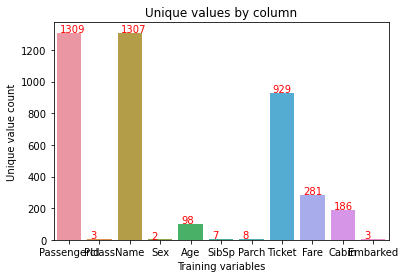

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

unique_count = X_data.nunique().reset_index()
unique_count.columns = ['Training variables', 'Unique value count']
plot = sns.barplot(x='Training variables', y='Unique value count', data=unique_count)
for i, v in enumerate(unique_count['Unique value count']):
    plot.text(i-0.3, v+5, str(v), color='red')
plt.title("Unique values by column")
plot

<div style="font-size: 12px"/>
Here we will map the titles in the Name class to specific titles to categorize the column

In [7]:
X_data['Title'] = X_data['Name']

# Cleaning name and extracting Title
for name_string in X_data['Name']:
    X_data['Title'] = X_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles
mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Major': 'Other',
           'Col': 'Other', 'Dr' : 'Other', 'Rev' : 'Other', 'Capt': 'Other',
           'Jonkheer': 'Royal', 'Sir': 'Royal', 'Lady': 'Royal',
           'Don': 'Royal', 'Countess': 'Royal', 'Dona': 'Royal'}

X_data.replace({'Title': mapping}, inplace=True)
titles = ['Miss', 'Mr', 'Mrs', 'Royal', 'Other', 'Master']

In [8]:
X_data = X_data.drop(['Name', 'PassengerId'], axis=1)

<div style="font-size: 12px"/>
As seen in the plot, Age has a relatively normal distribution
compared to Fare, which is skewed left. Some additional categorization is needed there.
Ticket and Cabin were not included as they are categorical variables

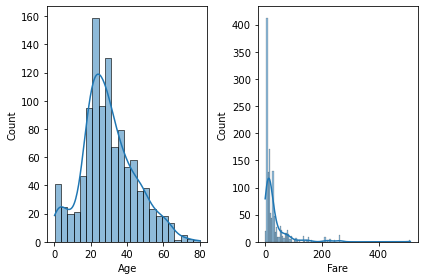

In [9]:
for i, col in enumerate(['Age', 'Fare']):
    plt.subplot(1, 2, i+1)
    plot = sns.histplot(X_data[col], kde=True)
    plt.tight_layout()

<div style="font-size: 12px"/>
There are 3 outliers in the Fare column, of the value
512.3292. It is better to split the Fare into categories to accomodate these.

In [10]:
X_data['Fare'].sort_values(ascending=False).head()

343    512.3292
258    512.3292
737    512.3292
679    512.3292
438    263.0000
Name: Fare, dtype: float64

In [11]:
fare_data = X_data['Fare'] # For future comparison
X_data['Fare'] = pd.cut(X_data['Fare'], bins=[0, 25, 75, 600], include_lowest=True,
                         labels=False)

<AxesSubplot:xlabel='Pclass'>

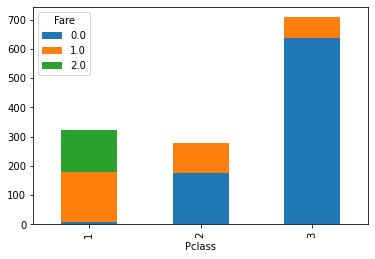

In [12]:
pd.crosstab(X_data['Pclass'], X_data['Fare']).plot(kind='bar', stacked=True)

<div style="font-size: 12px"/>
Age has 891 - 714 = 177 missing values. To fill these
we check the correlation between Age and other variables

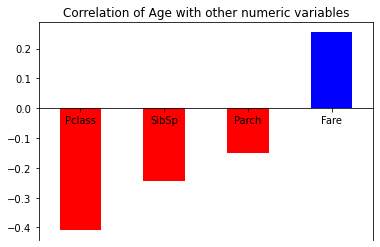

In [13]:
data = X_data.drop(['Age'], axis=1).corrwith(X_data['Age'])
plot = data.plot(kind='bar', color=(data > 0).map({True: 'b', False: 'r'}),
                 title='Correlation of Age with other numeric variables')
plot.spines['bottom'].set_position(('data', 0))

In [14]:
import numpy as np

age_data = X_data['Age'] # For future comparision
X_data['Age'] = X_data.apply(lambda row:
                               X_data[X_data['Pclass'] == row['Pclass']]['Age']
                               .mean() if np.isnan(row['Age']) else row['Age'], axis=1)
X_data['Age'] = pd.cut(X_data['Age'], bins=[0, 18, 56, 90], include_lowest=True,
                         labels=False)

In [15]:
print(any(X_data['Age'].isna()))

False


<div style="font-size: 12px"/>
As seen below, categorization provides a big boost to correlation for Age and Fare
with Survival

Text(0.7, 0.75, 'Age')

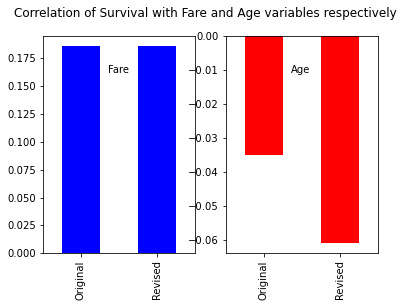

In [16]:
plt.suptitle('Correlation of Survival with Fare and Age variables respectively')

for i, group in enumerate(((fare_data, X_data['Fare']), (age_data, X_data['Age']))):
    data = pd.concat(group, axis=1).corrwith(y_train)
    plt.subplot(1, 2, i+1)
    plot = data.plot(kind='bar', color=(data > 0).map({True: 'b', False: 'r'}))
    plt.xticks([0,1], ['Original', 'Revised'])

plt.figtext(0.275, 0.75, 'Fare')
plt.figtext(0.7, 0.75, 'Age')

<div style="font-size: 12px"/> Embarked has 891 - 889 = 2 NaN values. We will fill those in
 using the mode of Embarked. In the plot this is seen to be C. It seems as if we can
 also merge some of the higher values in SibSp and Parch to make one hot encoding easier

In [17]:
X_data['Embarked'].fillna(X_data['Embarked'].mode()[0], inplace=True)
print(any(X_data['Embarked'].isna()))

False


<div style="font-size: 12px"/> The pie charts show that the higher values in SibSp and
Parch can be merged to have higher weight in the column

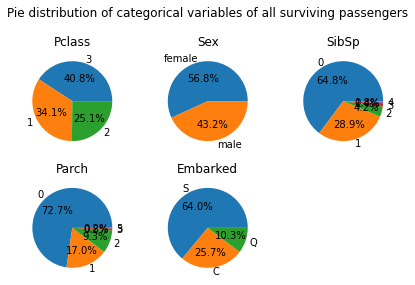

In [18]:
plt.suptitle("Pie distribution of categorical variables of all surviving passengers")

for i, col in enumerate(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']):
    plt.subplot(2, 3, i+1, title=col)
    survived = X_data[col].loc[y_train == 1].value_counts()
    plot = plt.pie(survived, labels=survived.index,
                   autopct='%1.1f%%')
    plt.tight_layout()

In [19]:
X_data['SibSp'] = pd.cut(X_data['SibSp'], bins=[0, 2, 5, 8], include_lowest=True,
                         labels=False)

In [20]:
X_data = X_data.drop(['Ticket', 'Cabin'] , axis=1)
X_data = X_data.astype(object)

In [21]:
X_data = pd.get_dummies(X_data, drop_first=True)
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Pclass_2     1309 non-null   uint8
 1   Pclass_3     1309 non-null   uint8
 2   Sex_male     1309 non-null   uint8
 3   Age_1        1309 non-null   uint8
 4   Age_2        1309 non-null   uint8
 5   SibSp_1      1309 non-null   uint8
 6   SibSp_2      1309 non-null   uint8
 7   Parch_1      1309 non-null   uint8
 8   Parch_2      1309 non-null   uint8
 9   Parch_3      1309 non-null   uint8
 10  Parch_4      1309 non-null   uint8
 11  Parch_5      1309 non-null   uint8
 12  Parch_6      1309 non-null   uint8
 13  Parch_9      1309 non-null   uint8
 14  Fare_1.0     1309 non-null   uint8
 15  Fare_2.0     1309 non-null   uint8
 16  Embarked_Q   1309 non-null   uint8
 17  Embarked_S   1309 non-null   uint8
 18  Title_Miss   1309 non-null   uint8
 19  Title_Mr     1309 non-null   uint8
 20  Title_Mrs

In [22]:
passenger_id = test_set['PassengerId']
X_train, test_set = X_data[:891], X_data[891:]

<div style="font-size: 12px"/>
Now that I am done with preprocessing I can proceed to finally train my model with
Convolutional Neural Networks

In [25]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(13, input_dim=23, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                312       
_________________________________________________________________
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 112       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [26]:
epochs=50
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=epochs)

Epoch 1/50
28/28 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6330
Epoch 2/50
28/28 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.6588
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 0.5696 - accuracy: 0.6801
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 0.5585 - accuracy: 0.7239

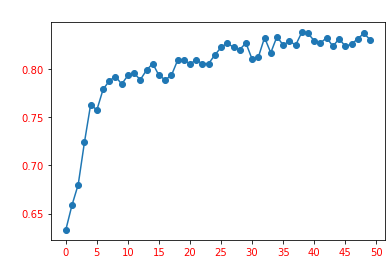

In [27]:
plt.plot(history.history['accuracy'], marker="o", label="training")
plt.xlabel('Number of Epochs', color='w')
plt.ylabel('Accuracy', color='w')
plt.title('Training accuracy over epochs', color='w')
plt.xticks(range(0, 55, 5))
[i.set_color("red") for i in plt.gca().get_xticklabels()]
[i.set_color("red") for i in plt.gca().get_yticklabels()]
plt.show()

In [28]:
prediction = [1 if value[0] >=0.5 else 0 for value in model.predict(test_set)]

submission = pd.DataFrame({
    "PassengerId": passenger_id.values,
    "Survived": prediction
})

submission.to_csv('submission.csv', index=False)